In [ ]:
%config IPCompleter.greedy=True

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-bcertificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2022-04-10 15:23:51--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com... 172.217.160.112, 142.251.43.16, 172.217.160.80, ...
Connecting to storage.googleapis.com|172.217.160.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: '/tmp/rps.zip'

/tmp/rps.zip        100%[===================>] 191.38M  4.91MB/s    in 35s     

2022-04-10 15:24:27 (5.40 MB/s) - '/tmp/rps.zip' saved [200682221/200682221]

--2022-04-10 15:24:27--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com... 142.251.43.16, 172.217.160.80, 142.251.42.240, ...
Connecting to storage.googleapis.com|142.251.43.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: '/tmp/rps-test-set.zip'

/tmp/rps-test-set.z 100%[===================>]  28.15M  10.0MB/s    in 2.8s    


In [2]:
import os
import zipfile

local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [ ]:
rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

rock_files = os.listdir(rock_dir)
paper_files = os.listdir(paper_dir)
scissors_files = os.listdir(scissors_dir)

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) for fname in rock_files[pic_index-2: pic_index]]

next_paper = [os.path.join(paper_dir, fname) for fname in paper_files[pic_index-2: pic_index]]

next_scissors = [os.path.join(scissors_dir, fname) for fname in scissors_files[pic_index-2: pic_index]]

for i, img_path in enumerate(next_rock + next_paper + next_scissors):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

In [ ]:
import tensorflow as tf
import keras_preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

In [9]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

2022-04-10 15:39:32.145860: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-10 15:39:32.146984: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.


In [10]:
history = model.fit_generator(train_generator, epochs=5, validation_data = validation_generator, verbose = 1)

model.save("rps.h5")

Epoch 1/5
79/79 [==============================] - 210s 3s/step - loss: 1.0847 - acc: 0.4004 - val_loss: 0.6249 - val_acc: 0.6909
Epoch 2/5
79/79 [==============================] - 216s 3s/step - loss: 0.8067 - acc: 0.6171 - val_loss: 0.2582 - val_acc: 0.8817
Epoch 3/5
79/79 [==============================] - 211s 3s/step - loss: 0.5442 - acc: 0.7798 - val_loss: 0.1336 - val_acc: 0.9704
Epoch 4/5
79/79 [==============================] - 212s 3s/step - loss: 0.3803 - acc: 0.8548 - val_loss: 0.0962 - val_acc: 0.9677
Epoch 5/5
79/79 [==============================] - 211s 3s/step - loss: 0.2400 - acc: 0.9123 - val_loss: 0.0971 - val_acc: 0.9570


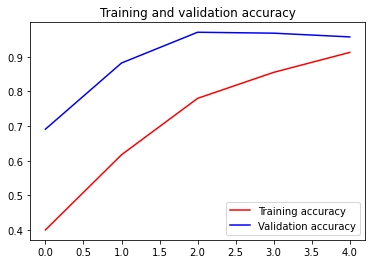

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

In [5]:
import tensorflow as tf
model = tf.keras.models.load_model('rps.h5')
model.summary()

AttributeError: 'str' object has no attribute 'decode'

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)